# CP Decomposition

In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
from tensorly.cp_tensor import CPTensor
from tensorly.tucker_tensor import TuckerTensor, tucker_to_tensor
from tensorly.tenalg import multi_mode_dot
import math
from tensorly.decomposition import parafac, non_negative_parafac
from scipy.interpolate import interp1d
import tlviz
import warnings

## Import tensors

In [313]:
tensor_70 = np.load('tensors/tensor_70.npy')
tensor_100 = np.load('tensors/tensor_100.npy')
tensor_200 = np.load('tensors/tensor_200.npy')
tensor_300 = np.load('tensors/tensor_300.npy')
tensor_70_log = np.load('tensors_log/tensor_70.npy')
tensor_100_log = np.load('tensors_log/tensor_100.npy')
tensor_200_log = np.load('tensors_log/tensor_200.npy')
tensor_300_log = np.load('tensors_log/tensor_300.npy')
tensor_70_cent = np.load('tensors_center/tensor_70.npy')
tensor_100_cent = np.load('tensors_center/tensor_100.npy')
tensor_200_cent = np.load('tensors_center/tensor_200.npy')
tensor_300_cent = np.load('tensors_center/tensor_300.npy')

## Number of components

In [318]:
# we create a list with the tensors for more efficient coding
tensors = [tensor_70, tensor_100, tensor_200, tensor_300]
tensor_names = ['70', '100', '200', '300']
tensors_log = [tensor_70_log, tensor_100_log, tensor_200_log, tensor_300_log]
tensor_names_log = ['70_log', '100_log', '200_log', '300_log']
tensors_cent = [tensor_70_cent, tensor_100_cent, tensor_200_cent, tensor_300_cent]
tensor_names_cent = ['70_cent', '100_cent', '200_cent', '300_cent']

### CORCONDIA

In [272]:
def visualization_corcondia(model, tensors, tensor_names):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes = axes.flatten()
    
    for i, (tensor, name) in enumerate(zip(tensors, tensor_names)):
        plt.sca(axes[i])
    
        models = {}
        for rank in [1, 2, 3, 4, 5, 6]:
            models[rank] = model(tensor, rank=rank)
        
        ax = tlviz.visualisation.scree_plot(models, tensor, metric="Core consistency")
        ax.set_ylim(0, 105)
        ax.set_title(f"tensor_{name}")
        ax.set_xlabel("Num of Comps.")

        ax.set_xticks([1, 2, 3, 4, 5, 6])

        corcondia_values = [ax.lines[0].get_ydata()[i] for i in [0, 1, 2, 3, 4, 5]]

        second = corcondia_values[1]
        third = corcondia_values[2]

        print(f"Corcondia value for Tensor {name}: {second}, {third}")
    
    plt.tight_layout()
    plt.show()

Corcondia value for Tensor 70: 68.58105554717626, -269.76189354941
Corcondia value for Tensor 100: 75.43341391418784, -660.1486690995679
Corcondia value for Tensor 200: 24.271226902562788, 35.29432931174155
Corcondia value for Tensor 300: 60.91473112627189, -38.05047297368134


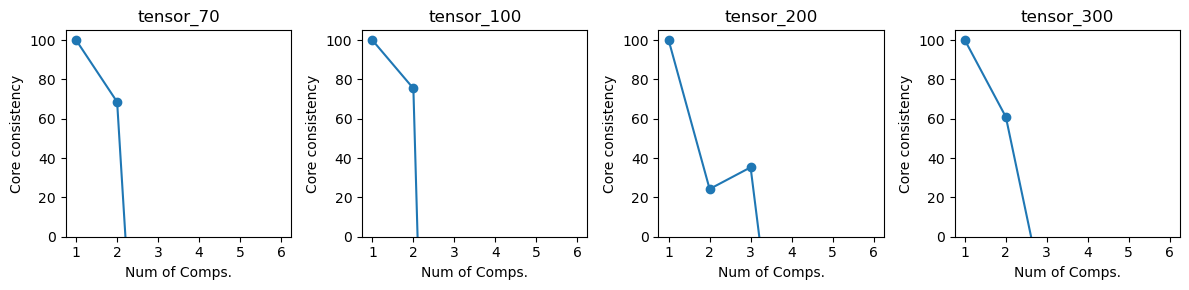

In [273]:
#non negative parafac - tensors
visualization_corcondia(non_negative_parafac, tensors, tensor_names)

Corcondia value for Tensor 70_log: 29.894648006481347, -401.63641287955755
Corcondia value for Tensor 100_log: 60.90664581771701, -268.62599292255254
Corcondia value for Tensor 200_log: -53.30869012233845, -145.33496971806662
Corcondia value for Tensor 300_log: -196.4763250433487, -227.4367245926967


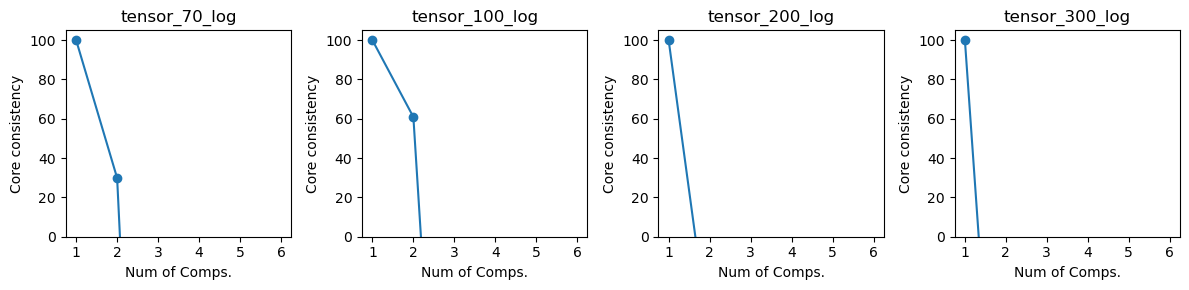

In [299]:
#non negative parafac - tensors_log
visualization_corcondia(non_negative_parafac, tensors_log, tensor_names_log)

Corcondia value for Tensor 70_cent: 98.63460456697338, -109.26237175212316
Corcondia value for Tensor 100_cent: 96.06965169367628, -73.23491190501679
Corcondia value for Tensor 200_cent: 99.99999681801211, 71.56302760528222
Corcondia value for Tensor 300_cent: 98.15532339281368, 4.398887843375704


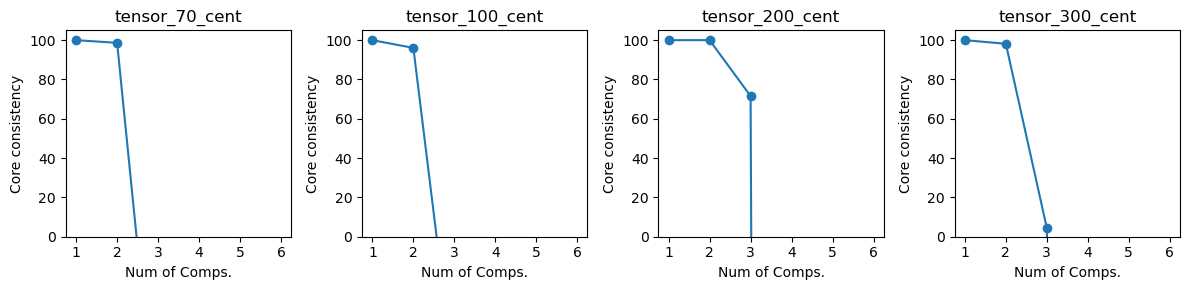

In [319]:
#parafac - tensors_cent
visualization_corcondia(parafac, tensors_cent, tensor_names_cent)

### Reconstruction error

In [205]:
def error(original, res):
    # res is in CP
    if isinstance(res, CPTensor):
        res = res.to_tensor()
    
    # deal with cases when res is Tucker
    if isinstance(res, TuckerTensor):
        res = tucker_to_tensor(res)
        
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

In [321]:
def visualization_error(model, tensors, tensor_names):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes = axes.flatten() 

    warnings.simplefilter("ignore", UserWarning)
    
    for ax, tensor, name in zip(axes, tensors, tensor_names):
        errors = pd.DataFrame(columns=["Num of Comps.", "Reconstruction error"])
        for rr in np.arange(1, 10):
            model_ = model(tensor, rank=rr, normalize_factors=True)
            err = error(tensor, model_)
            errors.loc[len(errors)] = [rr, err]
        
        sns.pointplot(data=errors, x="Num of Comps.", y="Reconstruction error", ax=ax)
        ax.set_title(f"tensor_{name}")
        ax.set_xticklabels(errors["Num of Comps."].astype(int))
    
    plt.tight_layout()
    plt.show()

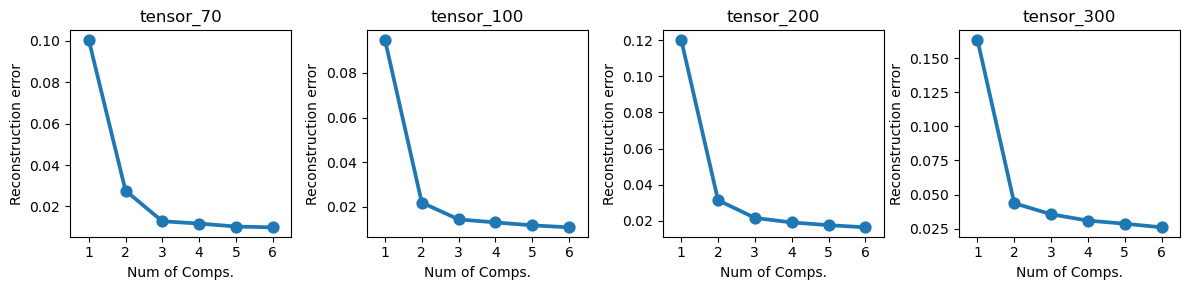

In [290]:
# non negative parafac - tensors
visualization_error(non_negative_parafac, tensors, tensor_names)

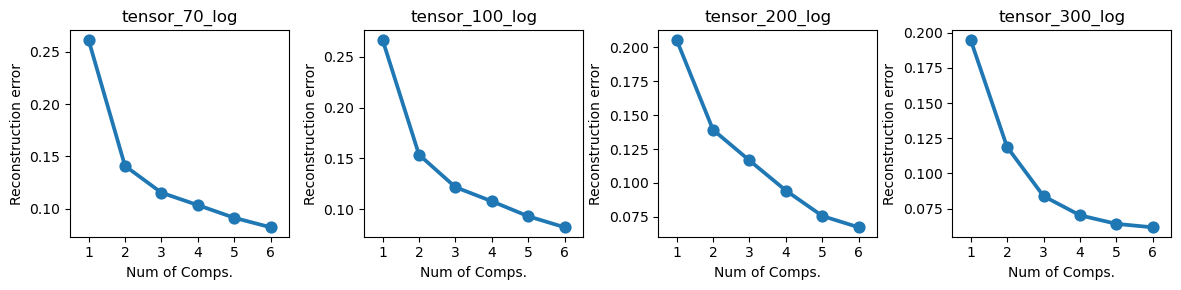

In [293]:
# non negative parafac - tensors_log
visualization_error(non_negative_parafac, tensors_log, tensor_names_log)

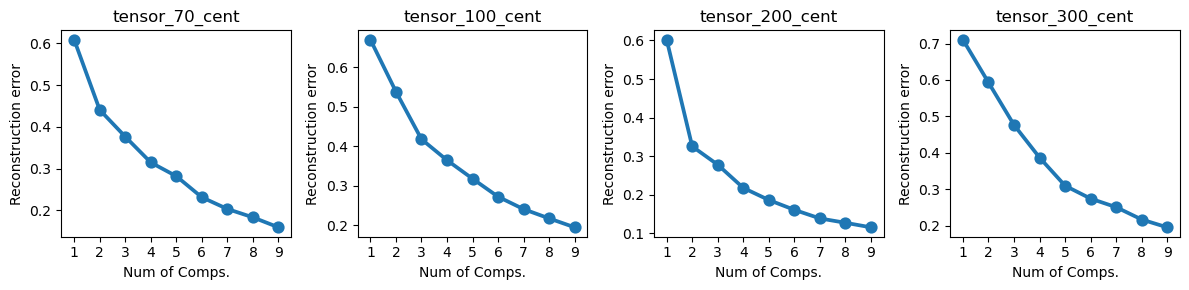

In [322]:
# parafac - tensors_cent
visualization_error(parafac, tensors_cent, tensor_names_cent)

## Decompositions

In [208]:
def decomposition_visualization(factors, patients):
    factor_labels = ["T Cells", "Days", "Patients"]
    x_labels = [range(f.shape[0]) for f in factors]
    
    num_components = factors[0].shape[1]
    
    fig, axes = plt.subplots(num_components, 3, figsize=(15, 4 * num_components))
    
    for component in range(num_components):
        for dim in range(3):
            ax = axes[component, dim]
            if dim == 0 or dim == 2:
                ax.bar(x_labels[dim], factors[dim][:, component], color='royalblue', alpha=0.8)
            else:
                ax.plot(x_labels[dim], factors[dim][:, component], marker='o', linestyle='-')
            ax.set_title(f"Component {component+1} - {factor_labels[dim]}")
            ax.set_xlabel(factor_labels[dim])
            ax.set_ylabel("Weight")
            if dim == 1:
                time_labels = [t * 10 for t in x_labels[dim]]
                ax.set_xticks(x_labels[dim])
                ax.set_xticklabels(time_labels)
                if len(time_labels) > 29:
                    step = 6
                elif len(time_labels) > 19:
                    step = 4
                elif len(time_labels) > 9:
                    step = 2 
                else:
                    step = 1 
                
                ax.set_xticks(x_labels[dim][::step])  # Reduce number of ticks
                ax.set_xticklabels(time_labels[::step]) 
            if dim == 2:
                ax.set_xticks(range(len(patients)))
                ax.set_xticklabels(patients, rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

### Tensor 70

#### Nonnegative PARAFAC

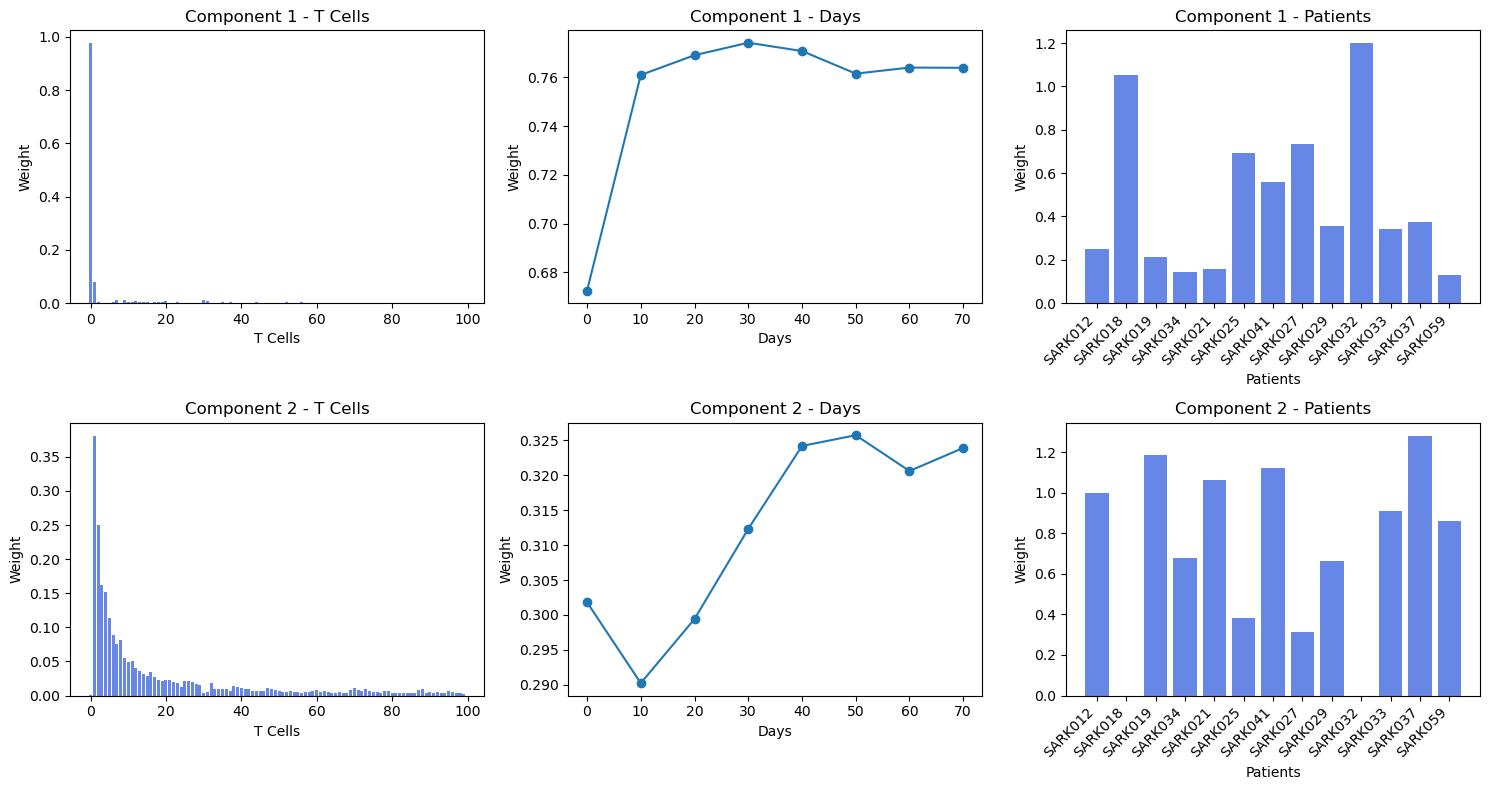

[1. 1.]


In [297]:
tensor_70 = tl.tensor(tensor_70)
weights_70, factors_70 = non_negative_parafac(tensor_70, rank=2, normalize_factors=False)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']
decomposition_visualization(factors_70, patients)
print(weights_70)

### Tensor 70_log 

#### Nonnegative PARAFAC

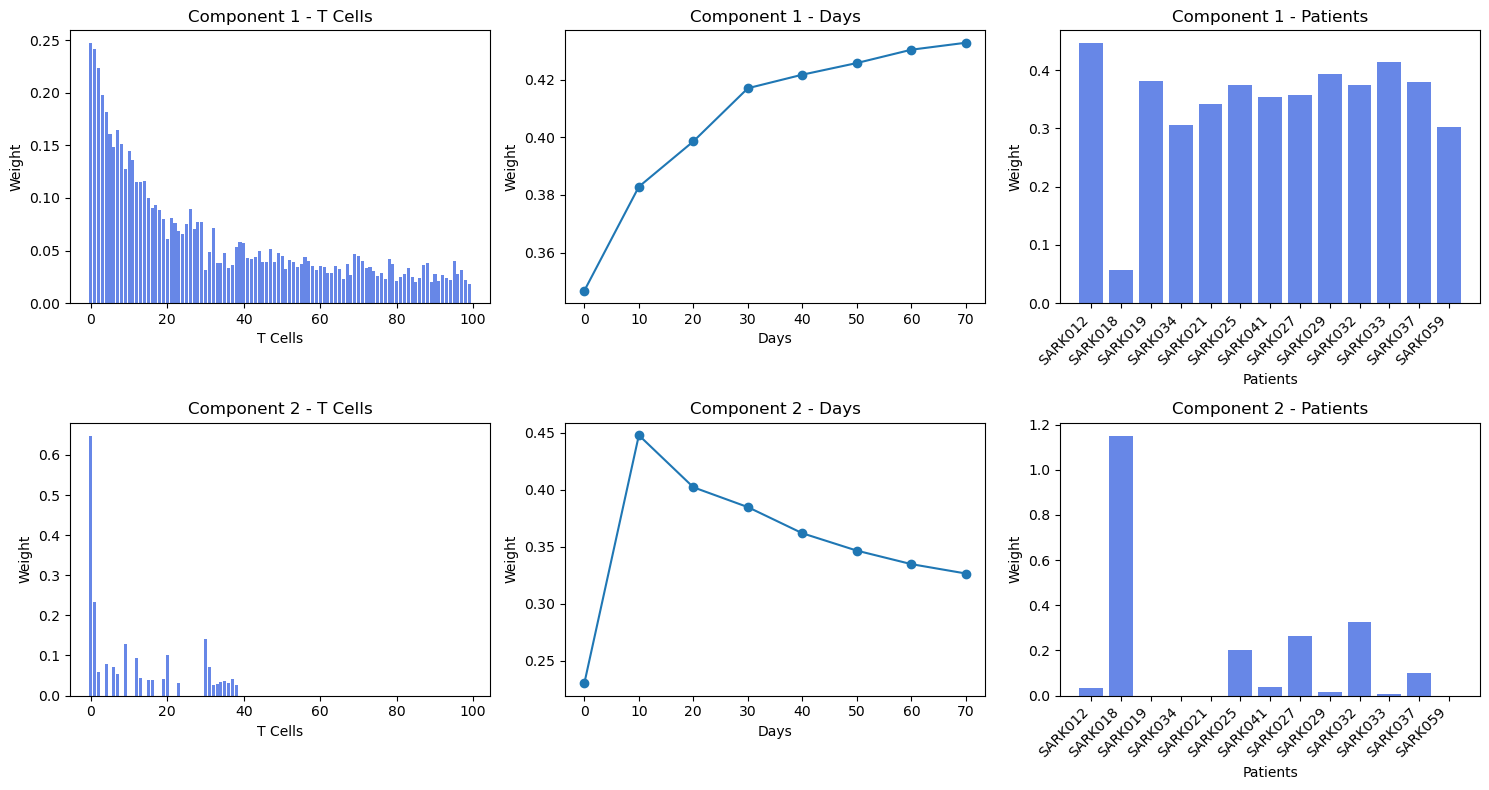

[1. 1.]


In [302]:
tensor_70_log = tl.tensor(tensor_70_log)
weights_70_log, factors_70_log = non_negative_parafac(tensor_70_log, rank=2, normalize_factors=False)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']
decomposition_visualization(factors_70_log, patients)
print(weights_70_log)

### Tensor 70_cent

#### PARAFAC

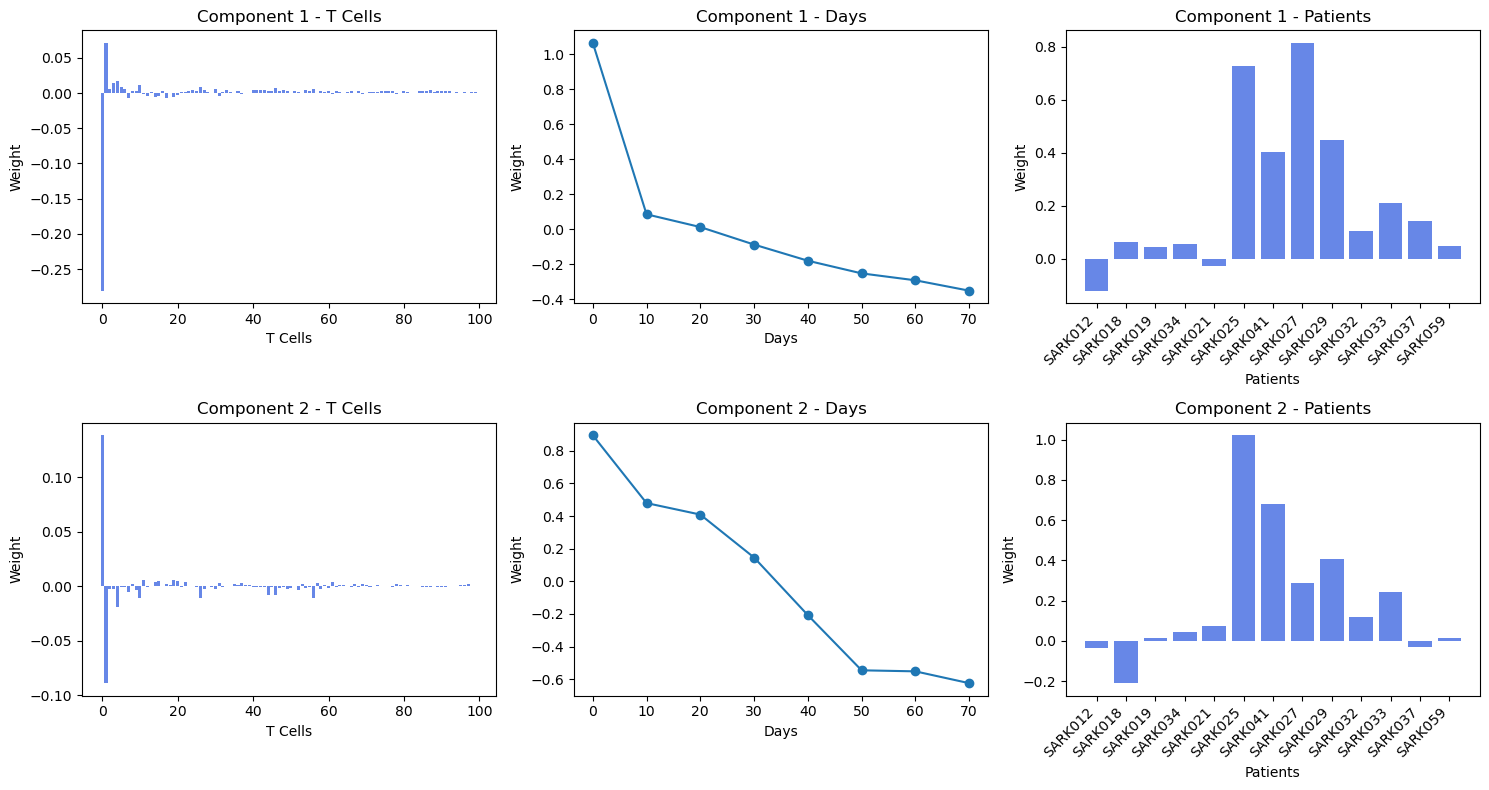

[1. 1.]


In [323]:
tensor_70_cent = tl.tensor(tensor_70_cent)
weights_70_cent, factors_70_cent = parafac(tensor_70_cent, rank=2, normalize_factors=False)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']
decomposition_visualization(factors_70_cent, patients)
print(weights_70_cent)

### Tensor 100

#### Nonnegative PARAFAC

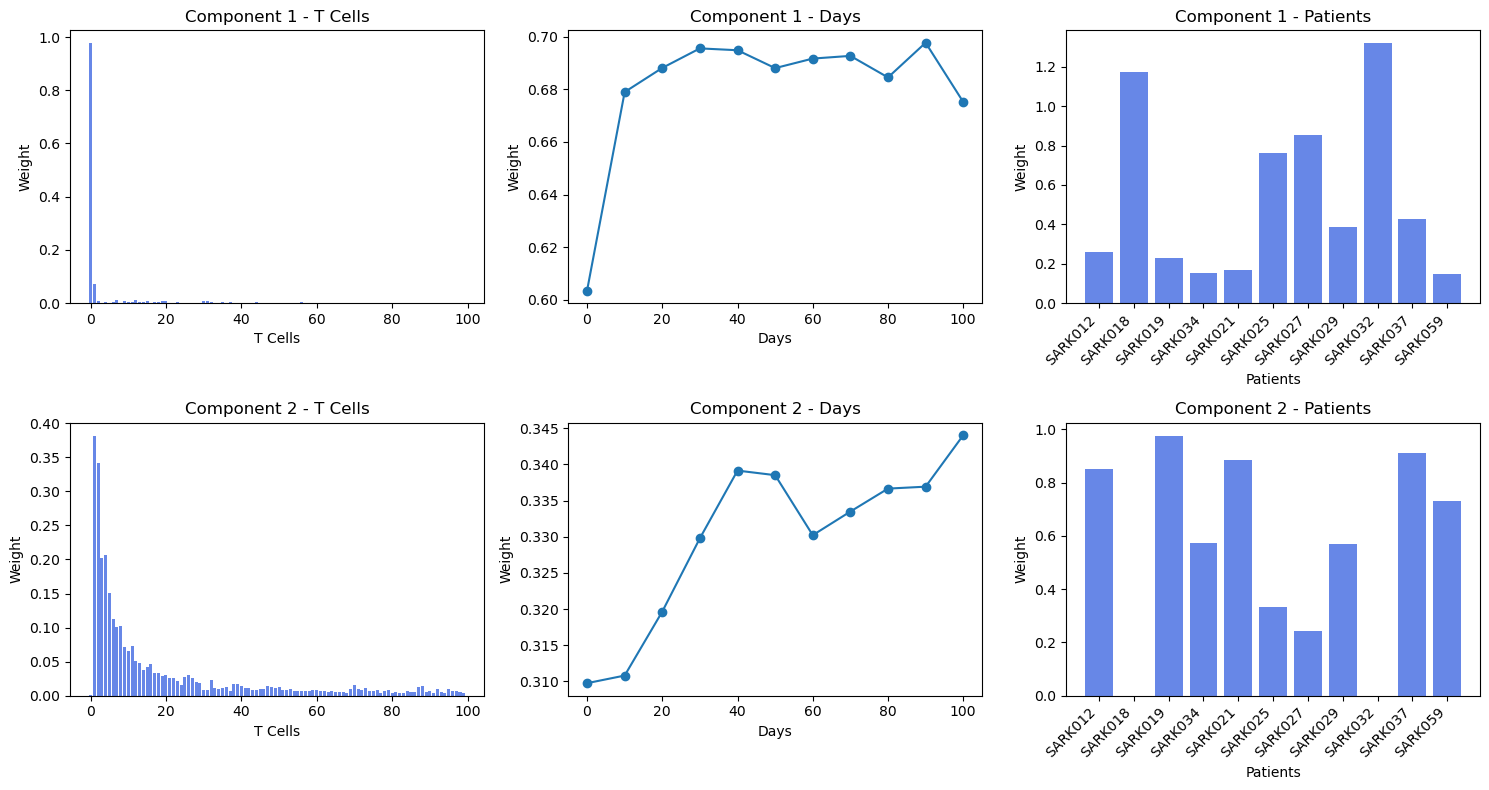

[1. 1.]


In [308]:
tensor_100 = tl.tensor(tensor_100)
weights_100, factors_100 = non_negative_parafac(tensor_100, rank=2, normalize_factors=False)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
decomposition_visualization(factors_100, patients)
print(weights_100)

### Tensor 100_log

#### Nonnegative PARAFAC 

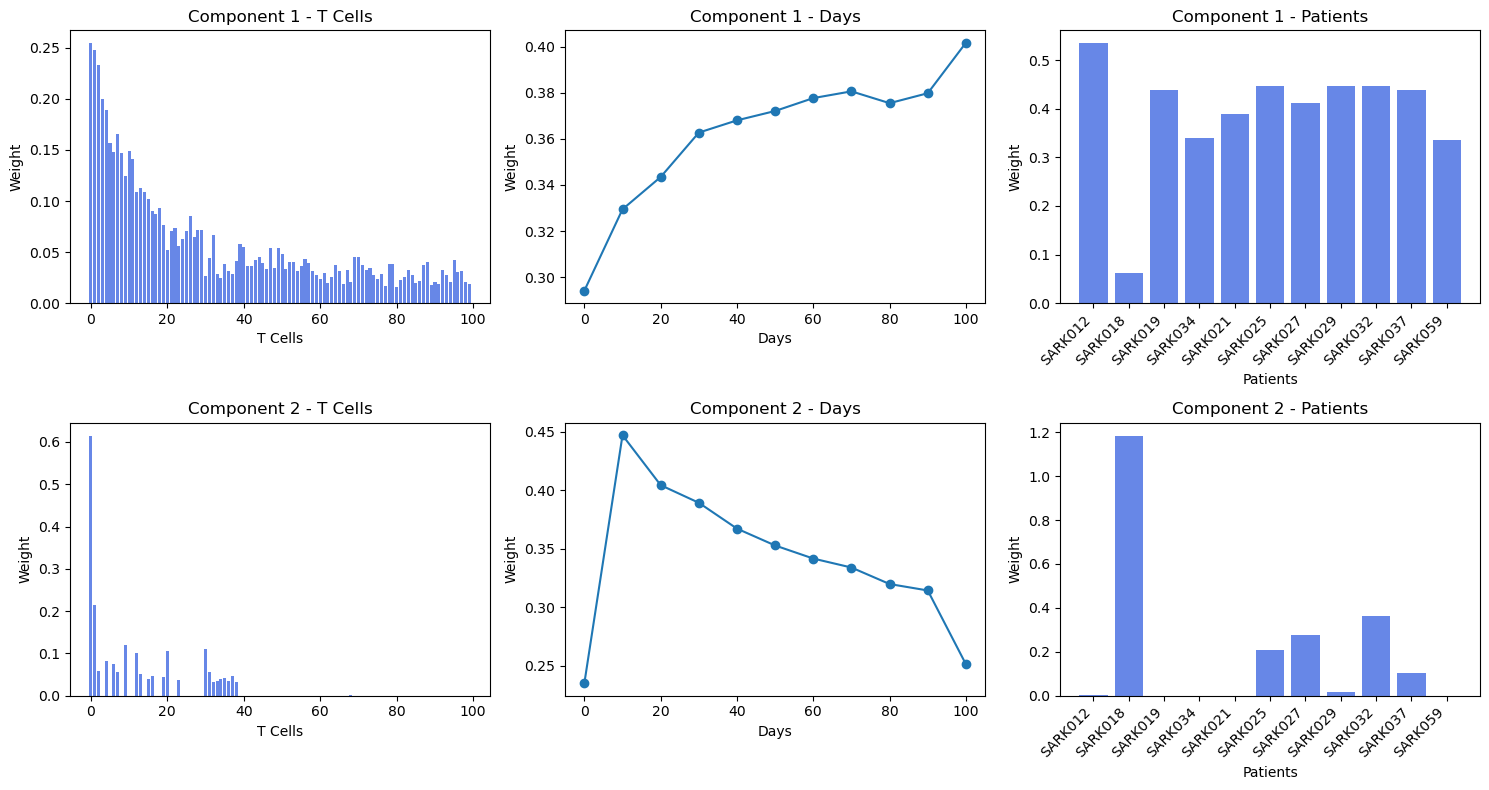

[1. 1.]


In [309]:
tensor_100_log = tl.tensor(tensor_100_log)
weights_100_log, factors_100_log = non_negative_parafac(tensor_100_log, rank=2, normalize_factors=False)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
decomposition_visualization(factors_100_log, patients)
print(weights_100_log)

### Tensor 100_cent

#### PARAFAC

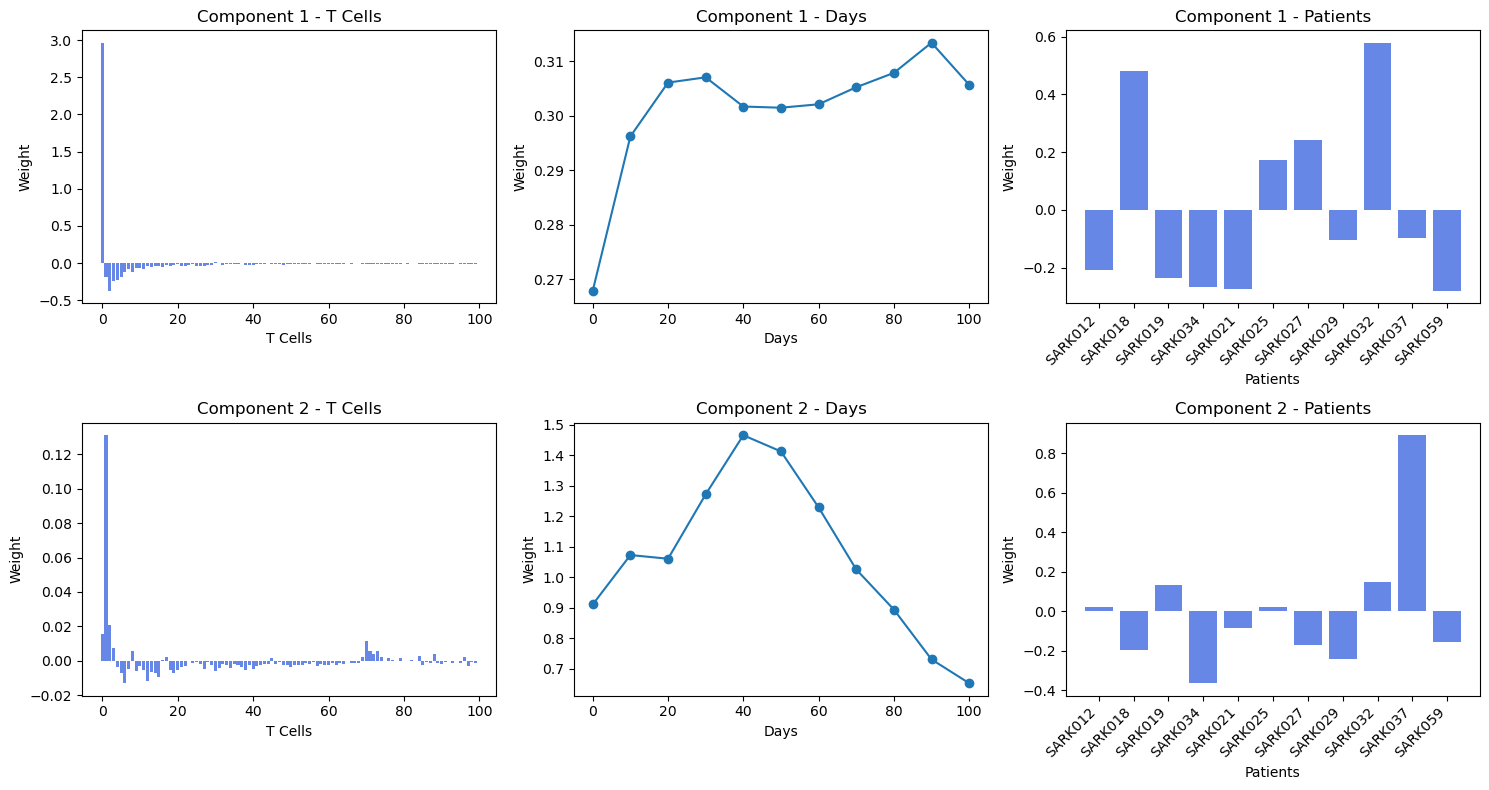

[1. 1.]


In [310]:
tensor_100_cent = tl.tensor(tensor_100_cent)
weights_100_cent, factors_100_cent = parafac(tensor_100_cent, rank=2, normalize_factors=False)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
decomposition_visualization(factors_100_cent, patients)
print(weights_100_cent)

### Tensor 200

#### Nonnegative PARAFAC (CP)

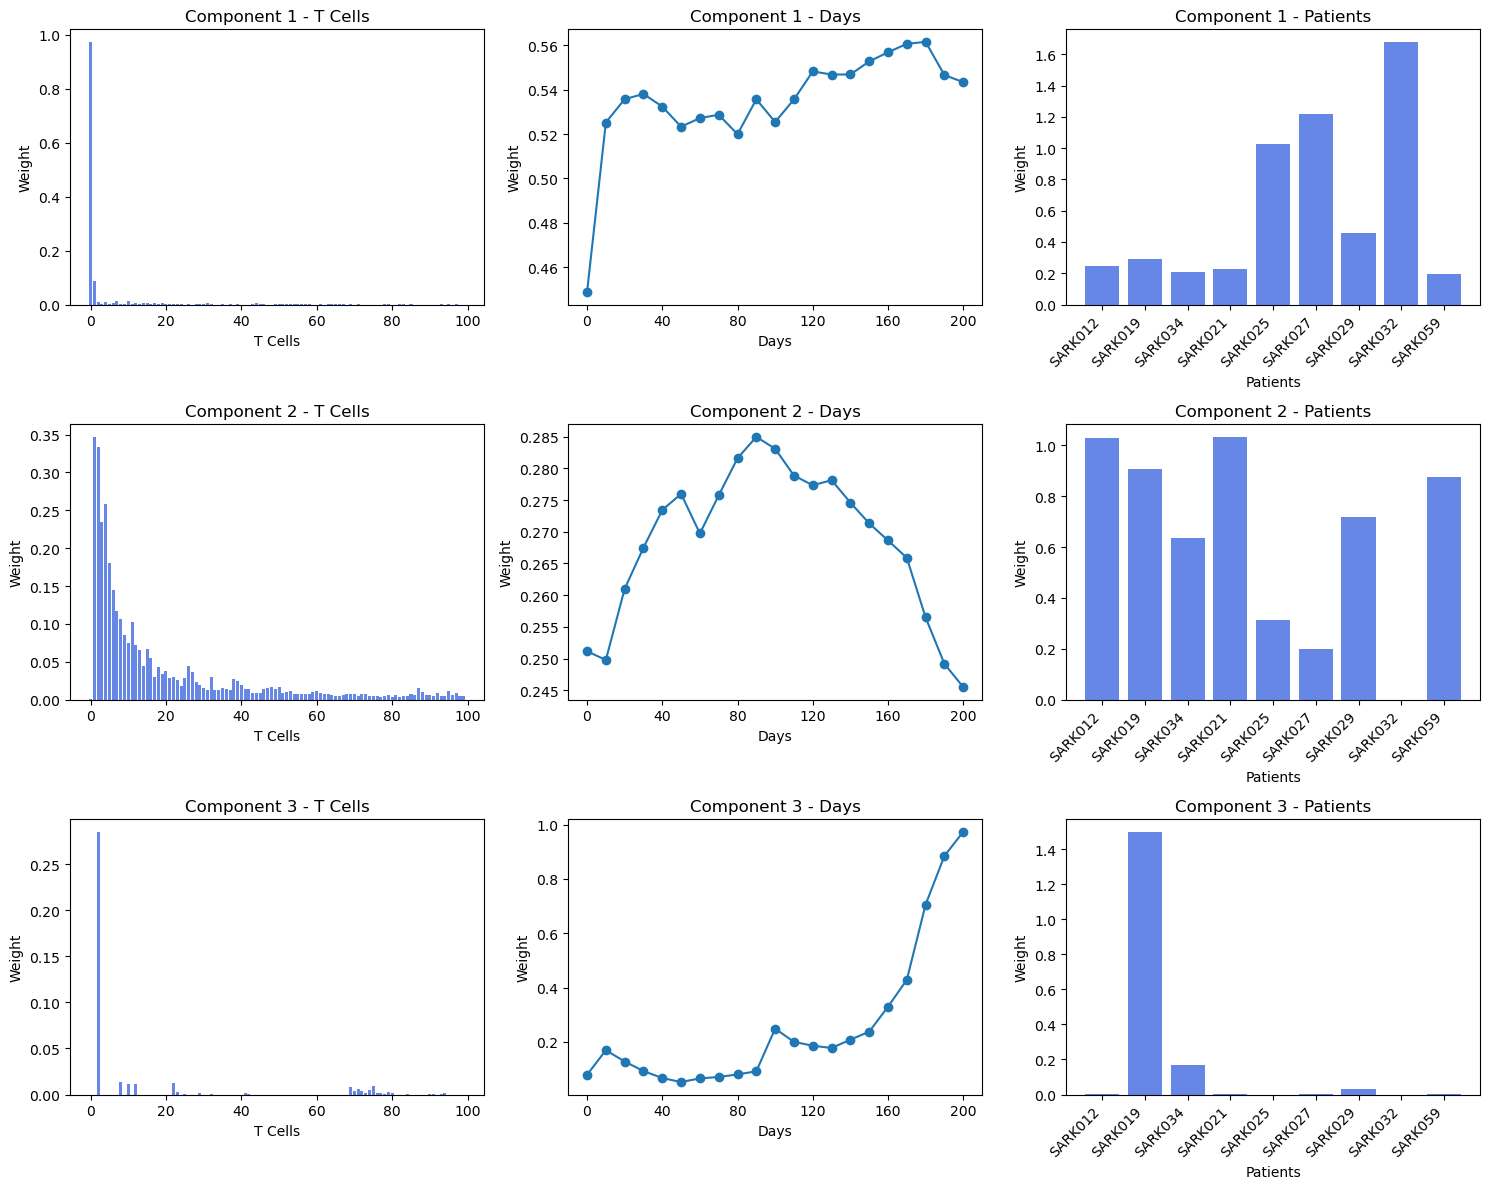

[1. 1. 1.]


In [311]:
tensor_200 = tl.tensor(tensor_200)
weights_200, factors_200 = non_negative_parafac(tensor_200, rank=3, normalize_factors=False)
patients = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
decomposition_visualization(factors_200, patients)
print(weights_200)

### Tensor 200_cent

#### PARAFAC

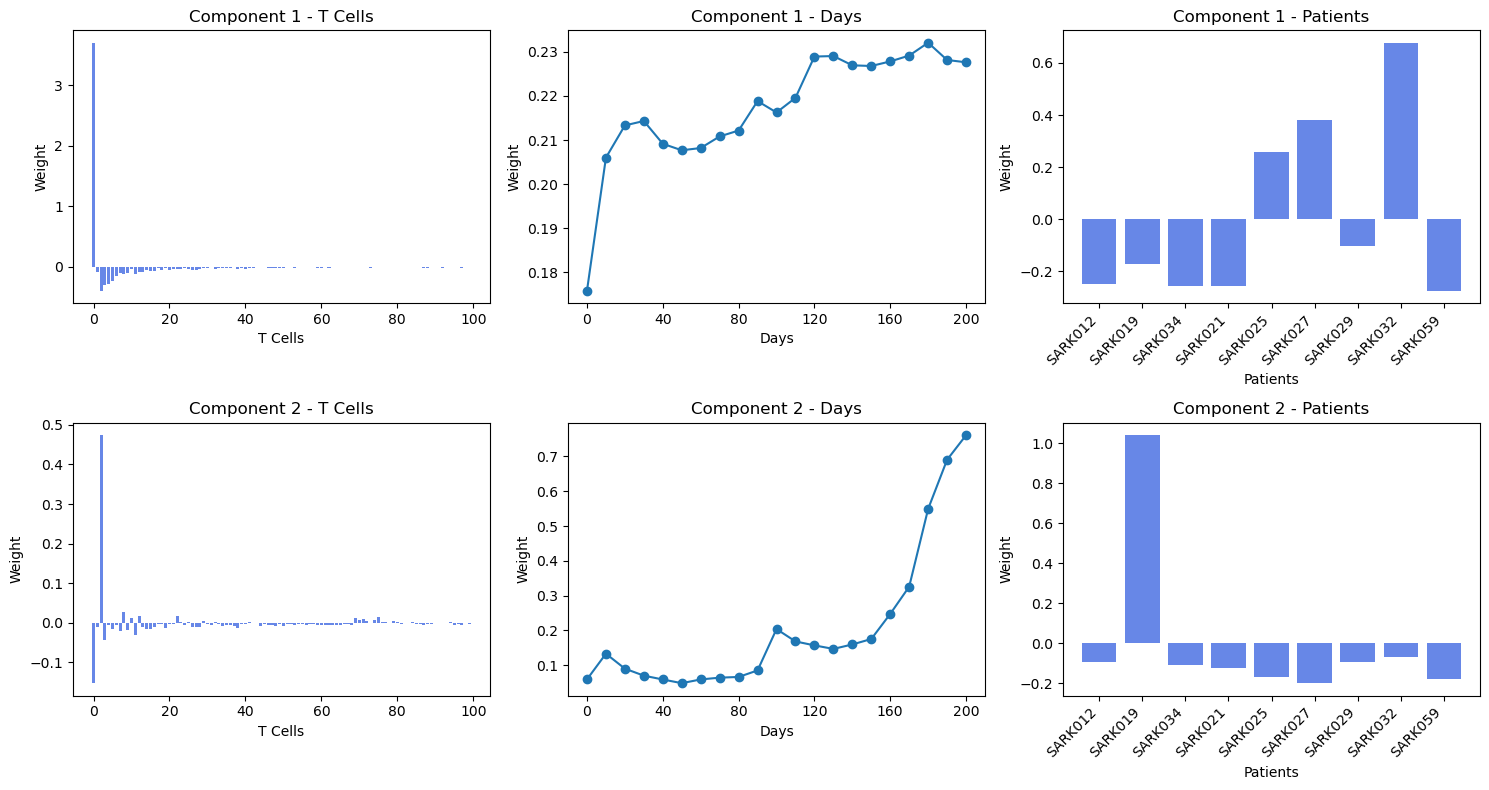

[1. 1.]


In [312]:
tensor_200_cent = tl.tensor(tensor_200_cent)
weights_200_cent, factors_200_cent = parafac(tensor_200_cent, rank=2, normalize_factors=False)
patients = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
decomposition_visualization(factors_200_cent, patients)
print(weights_200_cent)

### Tensor 300

#### Nonnegative PARAFAC (CP)

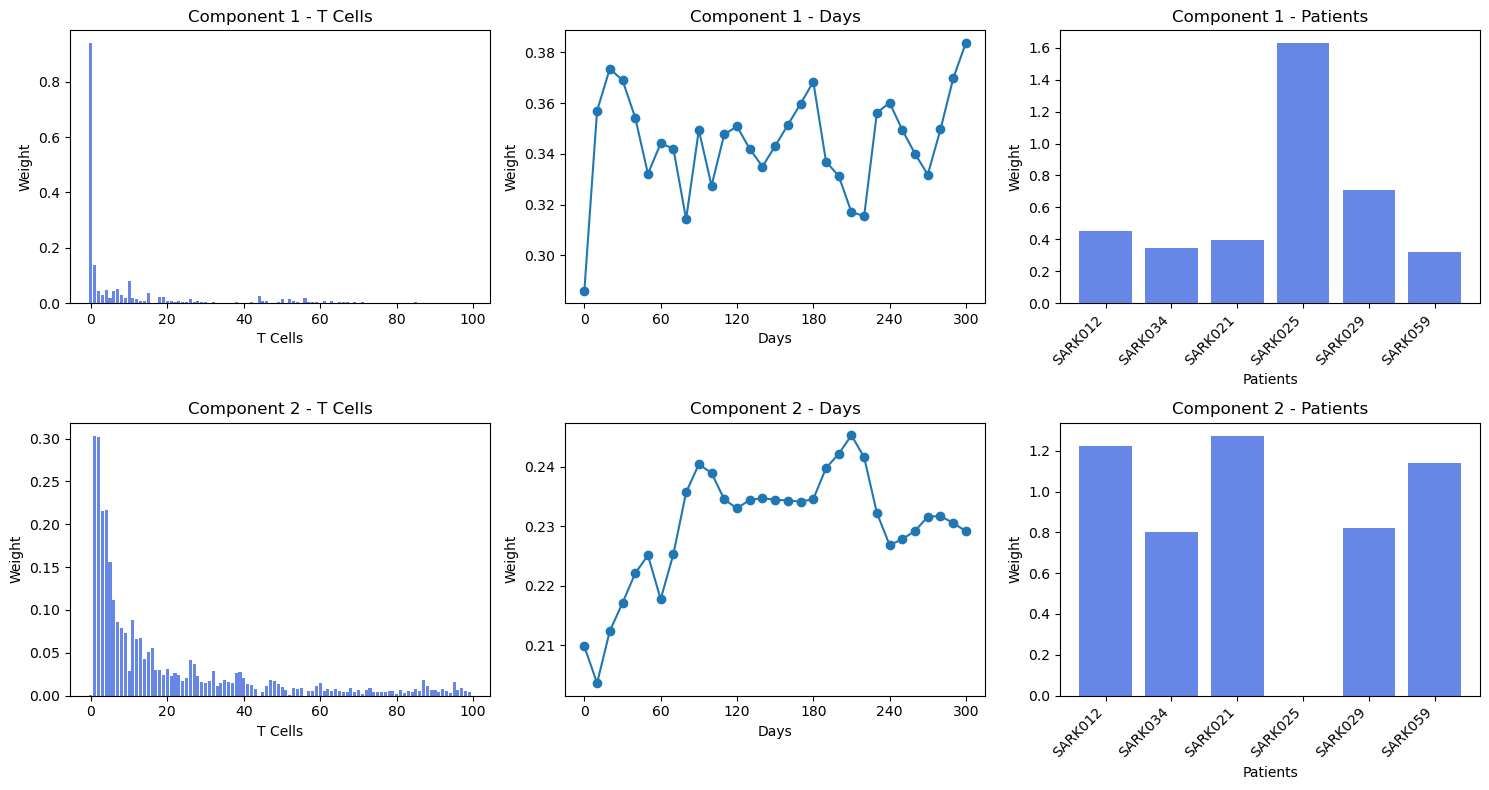

[1. 1.]


In [169]:
tensor_300 = tl.tensor(tensor_300)
weights_300, factors_300 = non_negative_parafac(tensor_300, rank=2, normalize_factors=False)
patients = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 'SARK029', 'SARK059']
decomposition_visualization(factors_300, patients)
print(weights_300)